# Pandas Vs. Polars Vs. Vaex - A Benchmarking Analysis.     
@Author: 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [42]:
#%%bash 
#pip3 install datatable
#!pip3 install 'modin[all]'
#pip3 install vaex
#pip3 install polars
#pip3 install pandas
#!pip3 install seaborn

In [2]:
import pandas as pd 
import vaex as vx 
import polars as pl 
import time
import seaborn as sns

## Create the benchmarking data

In [ ]:
df = pd.read_csv("./data/benchmark_data.csv")

#benchmarking_df = df.loc[df.index.repeat(100000)]
benchmarking_df = df.loc[df.index.repeat(50000)]

# Store the data for experimentation
benchmarking_df.to_csv("./data/diabetes_benchmark_data.csv")

## 1. Data Loading

In [3]:
# Initialize the benchmarking dictionary
loading_times = {}

# Benchmarking data path
benchmarking_data_path = "./data/diabetes_benchmark_data.csv"

In [4]:
# Helper function to perform the benchmarking analysis

def data_loading(library, data_path):
    
    lib = library.lower()
    
    match lib:
        
        case "pandas":
            t_start = time.time()
            pd_df = pd.read_csv(data_path)
            t_end = time.time() - t_start
  
            
        case "polars":
            t_start = time.time()
            pl_df = pl.read_csv(data_path)
            t_end = time.time() - t_start
            
        case "vaex":
            t_start = time.time()
            vx_df = vx.open(data_path)
            t_end = time.time() - t_start

    loading_times[lib] = t_end
            
        
# Helper function to plot the times

def plot_time(benchmark_time, plot_title):
    
    libraries = list(benchmark_time.keys())
    times = [float(t) for t in list(benchmark_time.values())]
    loading_plot = sns.barplot(x=libraries, y=times)

    loading_plot.set(xlabel ="Libraries", ylabel = "Time", title =plot_title)

In [69]:
loading_times

{'pandas': 35.10708403587341,
 'polars': 4.170284032821655,
 'vaex': 1.1364898681640625}

### Pandas

In [5]:
data_loading("pandas", benchmarking_data_path)

### Polars

In [6]:
data_loading("polars", benchmarking_data_path)

### Vaex

In [7]:
data_loading("vaex", benchmarking_data_path)

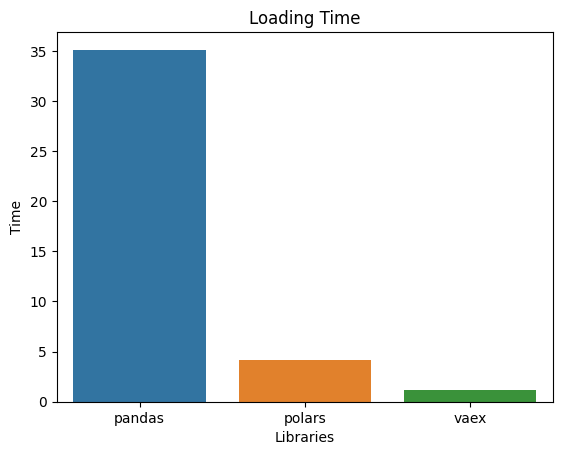

In [8]:
plot_time(loading_times, "Loading Time")

## 2. Data Offloading

In [9]:
offloading_times = {}

In [10]:
# Offloading function
def offdata_loading(library, df):
    
    lib = library.lower()
    
    if(lib == "pandas" or lib == "polars"):
        t_start = time.time()
        df.to_numpy()
        t_end = time.time() - t_start  
        
    elif(lib == "vaex"):
        t_start = time.time()
        df.values
        t_end = time.time() - t_start
    
    offloading_times[lib] = t_end    

In [11]:
pd_df = pd.read_csv(benchmarking_data_path)
pl_df = pl.read_csv(benchmarking_data_path)
vx_df = vx.open(benchmarking_data_path)

In [12]:
offdata_loading("pandas", pd_df)
offdata_loading("polars", pl_df)
offdata_loading("vaex", vx_df)

In [13]:
offloading_times

{'pandas': 7.351977109909058,
 'polars': 7.777760982513428,
 'vaex': 36.03146696090698}

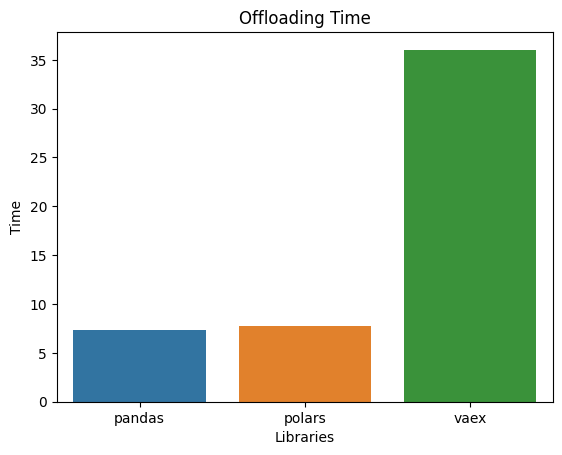

In [14]:
plot_time(offloading_times, "Offloading Time")

## 3. Data Grouping

In [25]:
aggregation_time = {}

In [26]:
def grouping_data(library, df):
    
    lib = library.lower()
    
    if(library == "pandas"):
        
        t_start = time.time()  
        df.groupby(["Outcome"], 
                      as_index = False)[['Age']].mean()
        t_end = time.time() - t_start
    
    elif(library == "vaex"):
        t_start = time.time()  
        df.groupby('Outcome', agg=vx.agg.mean(df.Age))
        t_end = time.time() - t_start  
        
    elif(library == "polars"):
        t_start = time.time()  
        df.groupby(['Outcome']).agg(pl.col("Age").mean())
        t_end = time.time() - t_start        
        
    aggregation_time[lib] = t_end

In [ ]:
"""
pd_df.groupby(["Outcome"], 
                      as_index = False)[['Age']].mean()
                      
vx_df.groupby('Outcome', agg=vx.agg.mean(vx_df.Age))

pl_df.groupby(['Outcome']).agg(pl.col("Age").mean())
"""

In [27]:
grouping_data("pandas", pd_df)
grouping_data("polars", pl_df)
grouping_data("vaex", vx_df)

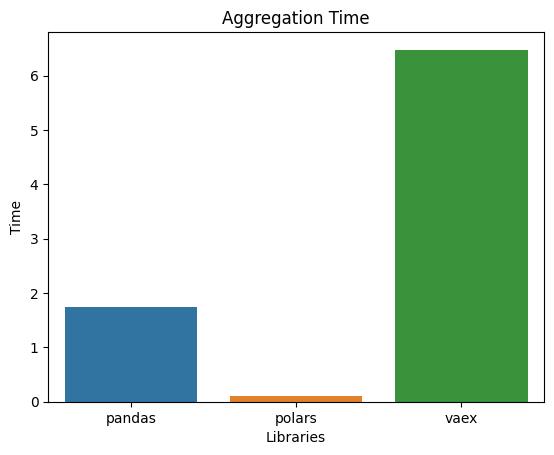

In [28]:
plot_time(aggregation_time, "Aggregation Time")

In [70]:
aggregation_time

{'pandas': 1.7471179962158203,
 'polars': 0.10506319999694824,
 'vaex': 6.478858947753906}

## 4. Data Sorting

In [50]:
sorting_time = {}

In [49]:
def sorting_data(library, df):
    
    lib = library.lower()
    
    if(library == "pandas"):
        
        t_start = time.time()  
        df.sort_values(by='Pregnancies')
        t_end = time.time() - t_start
    
    elif(library == "vaex"):
        t_start = time.time()  
        df.sort('Pregnancies')
        t_end = time.time() - t_start  
        
    elif(library == "polars"):
        t_start = time.time()  
        df.sort(['Pregnancies'])
        t_end = time.time() - t_start        
        
    sorting_time[lib] = t_end

In [51]:
sorting_data("pandas", pd_df)
sorting_data("polars", pl_df)
sorting_data("vaex", vx_df)

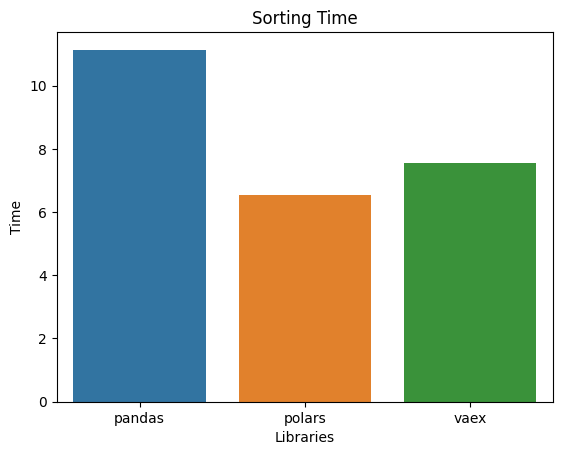

In [52]:
plot_time(sorting_time, "Sorting Time")

In [72]:
sorting_time

{'pandas': 11.134397983551025,
 'polars': 6.538980007171631,
 'vaex': 7.563628196716309}

## 5. Data Filtering

In [65]:
filtering_time = {}

In [66]:
def filtering_data(library, df, column_name, value):
    
    lib = library.lower()
    
    if(library == "pandas"):
        
        t_start = time.time()  
        pd_df[pd_df[str(column_name)] > value]
        t_end = time.time() - t_start
    
    elif(library == "vaex"):
        t_start = time.time()  
        df.filter(df[str(column_name)] > value)
        t_end = time.time() - t_start  
        
    elif(library == "polars"):
        t_start = time.time()  
        df.filter(pl.col(str(column_name)) > value)
        t_end = time.time() - t_start        
        
    filtering_time[lib] = t_end

In [67]:
filtering_data("pandas", pd_df, "BloodPressure", 74)
filtering_data("polars", pl_df, "BloodPressure", 74)
filtering_data("vaex", vx_df, "BloodPressure", 74)

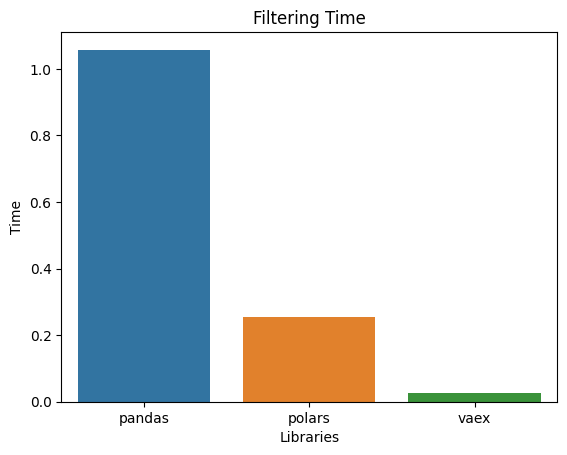

In [68]:
plot_time(filtering_time, "Filtering Time")

In [71]:
filtering_time

{'pandas': 1.05745530128479,
 'polars': 0.25542688369750977,
 'vaex': 0.02597212791442871}